# Project 2 - Singapore Housing Data and Kaggle Challenge

## Part 4 - Feature Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
# Importing data.
df = pd.read_csv('../data/03_first_model.csv')

As mentioned in the previous notebook, there are multicollinearity issues based on the original OLS results. So, I will dive down into the columns to identify which ones are likely to have a strong correlation with each other.

## 1. Feature Selection (1st iteration)

### 1.1 Round 1 (numerical columns)

Based on the previous notebook, we used the OLS regression using `statsmodels`, along with the VIF and correlation heatmap to identify more columns to drop. These are:
1. vacancy
2. cutoff_point
3. total_dwelling_units
4. hawker_food_stalls
5. bus_stop_nearest_distance
6. max_floor_lvl
7. market_hawker
8. multistorey_carpark
9. precinct_pavilion
10. hawker_market_stalls
11. bus_interchange
12. affiliation

As such, we will drop these columns.

In [3]:
df.drop(columns = ['vacancy', 'cutoff_point', 'total_dwelling_units', 'hawker_food_stalls',
                  'bus_stop_nearest_distance', 'max_floor_lvl', 'market_hawker', 
                   'multistorey_carpark', 'precinct_pavilion', 'hawker_market_stalls',
                  'bus_interchange', 'affiliation'], inplace = True)

In [4]:
df.shape

(149772, 16)

Our new DataFrame has 16 columns, much smaller than the original 77 columns!

In [5]:
# Defining numerical columns and categorical columns to be passed through SS and OHE respectively

num_columns = ['floor_area_sqm', 'mid_storey', 
                'mall_nearest_distance', 'hawker_nearest_distance',
                'mrt_nearest_distance',
               'pri_sch_nearest_distance', 
               'sec_sch_nearest_dist',
                'age_when_sold']

cat_columns = ['full_flat_type', 'commercial', 
               'planning_area',  'mrt_interchange',  
                'pri_sch_affiliation', 'pri_sch_name', 'sec_sch_name']

### 1.2 Edited Model 1

Now that we've done the first round of feature selection, let us run the Linear Regression model again to see if there are any issues in terms of overfitting or underfitting (the latter being more likely than the former, considering we dropped more columns).

In [6]:
X = df.drop(columns= ['resale_price'])
y = df['resale_price']

In [7]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) 

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112329, 15)
(37443, 15)
(112329,)
(37443,)


In [8]:
# Instantiating OHE, SS and CT
ohe = OneHotEncoder(min_frequency = 10)
ss = StandardScaler()
ct = make_column_transformer(
    (ohe, cat_columns),
    (ss, num_columns))

In [9]:
# Instantiating LinearRegression
lr = LinearRegression()
# Creating a pipeline that starts off with the column transformer, followed by the LinearRegression
lr_pipe = make_pipeline(ct, lr)

In [10]:
lr_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(min_frequency=10),
                                                  ['full_flat_type',
                                                   'commercial',
                                                   'planning_area',
                                                   'mrt_interchange',
                                                   'pri_sch_affiliation',
                                                   'pri_sch_name',
                                                   'sec_sch_name']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'mid_storey',
                                                   'mall_nearest_distance',
                                                   'hawker_nearest_distance',
                                                   'mrt_nearest_distance',
                                                   'pri_sch_nearest_distance',
                                                   'sec_sch_nearest_dist',
                                                   'age_when_sold'])])),
                ('linearregression', LinearRegression())])

In [11]:
# Running a fit on the train dataset
lr_pipe.fit(X_train, y_train)

# Finding the score on the train and test dataset
print(f"The train score is: {lr_pipe.score(X_train, y_train)}")
print(f"The test score is: {lr_pipe.score(X_test, y_test)}")

y_test_preds_lr = lr_pipe.predict(X_test)

# Linear Regression Root Mean Squared Error
lr_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds_lr))
print(f'The root mean squared error is {lr_rmse}.')

The train score is: 0.9094461971305231
The test score is: 0.9085714834872526
The root mean squared error is 43304.097016923675.


After removing 12 columns, the RMSE went up by only 295.

Let us check if there is any more multicollinearity.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
vif_columns = df[num_columns]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = vif_columns.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(vif_columns.values, i)
                          for i in range(len(vif_columns.columns))]
  
print(vif_data)

                    feature       VIF
0            floor_area_sqm  9.782558
1                mid_storey  3.146272
2     mall_nearest_distance  4.509676
3   hawker_nearest_distance  2.660938
4      mrt_nearest_distance  4.123332
5  pri_sch_nearest_distance  4.181882
6      sec_sch_nearest_dist  3.741386
7             age_when_sold  5.291263


While the VIF scores are quite high for 'floor_area_sqm' and 'age_when_sold', it is still below 10, which is the threshold for extremely high multicollinearity.

## 2. Feature Selection (2nd iteration)

### 2.1 Round 2 (outliers)

Now that we have the determined the columns, let us explore the outliers for each numerical columns.

In [13]:
# Defining numerical columns and categorical columns

num_columns = ['floor_area_sqm', 'mid_storey', 
                'mall_nearest_distance', 'hawker_nearest_distance',
                'mrt_nearest_distance',
               'pri_sch_nearest_distance', 
               'sec_sch_nearest_dist',
                'age_when_sold']

cat_columns = ['full_flat_type', 'commercial', 
               'planning_area',  'mrt_interchange',  
                'pri_sch_affiliation', 'pri_sch_name', 'sec_sch_name']

We will find outliers in each numerical column using the 3-sigma rule.

In [14]:
# Creating a 'for' loop to find outliers

outliers = pd.DataFrame()
for column in df[num_columns].columns:
        upper_bound = (df[column].mean()) + ((df[column].std()) * 3)
        lower_bound = (df[column].mean()) - ((df[column].std()) * 3)
        outlier_rows = df[(df[column] >= upper_bound) | (df[column] <= lower_bound)]
        print(f"Column: {column}, Upper Bound: {upper_bound}, Lower Bound: {lower_bound}")
        print(f"Column: {column}, Outliers: {len(outlier_rows)}")
        outliers = pd.concat([outliers, outlier_rows])

outliers

Column: floor_area_sqm, Upper Bound: 170.54673745835677, Lower Bound: 23.9038514367638
Column: floor_area_sqm, Outliers: 418
Column: mid_storey, Upper Bound: 24.71029789965162, Lower Bound: -8.1838042960408
Column: mid_storey, Outliers: 2332
Column: mall_nearest_distance, Upper Bound: 1770.5771101438052, Lower Bound: -441.990656739001
Column: mall_nearest_distance, Outliers: 1961
Column: hawker_nearest_distance, Upper Bound: 4380.771948909137, Lower Bound: -2045.89670400872
Column: hawker_nearest_distance, Outliers: 1164
Column: mrt_nearest_distance, Upper Bound: 2051.4763549886893, Lower Bound: -523.2742845444892
Column: mrt_nearest_distance, Outliers: 1877
Column: pri_sch_nearest_distance, Upper Bound: 1097.5158689619425, Lower Bound: -307.60567430565186
Column: pri_sch_nearest_distance, Outliers: 2526
Column: sec_sch_nearest_dist, Upper Bound: 1433.9921433792867, Lower Bound: -418.7207695149432
Column: sec_sch_nearest_dist, Outliers: 2245
Column: age_when_sold, Upper Bound: 59.62790

,floor_area_sqm,resale_price,mid_storey,full_flat_type,commercial,planning_area,mall_nearest_distance,hawker_nearest_distance,mrt_nearest_distance,mrt_interchange,pri_sch_nearest_distance,pri_sch_name,pri_sch_affiliation,sec_sch_nearest_dist,sec_sch_name,age_when_sold
268,189.0,798000.0,11,EXECUTIVE Apartment,0,Woodlands,692.119048,1091.025481,577.773293,1,160.645700,Qihua Primary School,0,205.057334,Riverside Secondary School,21
281,177.0,735000.0,8,EXECUTIVE Apartment,0,Woodlands,876.171122,891.406184,268.533032,0,406.285043,Marsiling Primary School,0,544.076771,Fuchun Secondary School,18
369,280.0,1060000.0,2,3 ROOM Terrace,0,Novena,1072.225651,572.821170,1036.395130,0,752.791589,Hong Wen School,0,678.037848,Bendemeer Secondary School,43
1248,243.0,1092888.0,8,EXECUTIVE Maisonette,0,Bishan,450.118063,850.323833,1405.412952,0,329.618668,Ai Tong School,0,956.557404,Peirce Secondary School,31
1413,177.0,700000.0,5,EXECUTIVE Apartment,0,Woodlands,888.855964,904.019293,297.433396,0,442.833194,Marsiling Primary School,0,543.374994,Fuchun Secondary School,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149321,128.0,500000.0,5,5 ROOM Improved,0,Pasir Ris,983.945672,2045.213606,1834.398934,0,223.838026,Meridian Primary School,0,2076.712972,Meridian Secondary School,18
149344,68.0,372000.0,8,3 ROOM New Generation,1,Kallang,683.052713,129.482562,383.366751,0,293.343061,Farrer Park Primary School,0,1545.212981,Bendemeer Secondary School,35
149393,68.0,330000.0,17,3 ROOM Improved,1,Kallang,384.637146,206.316540,408.787148,0,867.194879,Stamford Primary School,0,1972.859491,Raffles Girls' School,41
149414,54.0,298000.0,5,2 ROOM Improved,1,Bukit Merah,945.979936,279.460289,119.249523,0,496.947492,Blangah Rise Primary School,0,1498.405165,CHIJ Saint Theresa's Convent,36


As we can see, the outliers make up 12523 rows, which is 8% of the total number of rows that is 149772; quite a high number. Additionally, there is no strong reason to definitively say that we should drop the outliers. Thus, we will not be dropping the outliers.

## 3. Final DataFrame

### 3.1 DataFrame

Let us see the final DataFrame that we will be using for our model.

In [15]:
df.head()
df.shape

(149772, 16)

Here is the correlation heatmap for the DataFrame.

/var/folders/w4/0rkrlv1d2cg4g7rbby5yb_tr0000gn/T/ipykernel_3528/2906231933.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr()))
/var/folders/w4/0rkrlv1d2cg4g7rbby5yb_tr0000gn/T/ipykernel_3528/2906231933.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', mask = mask)


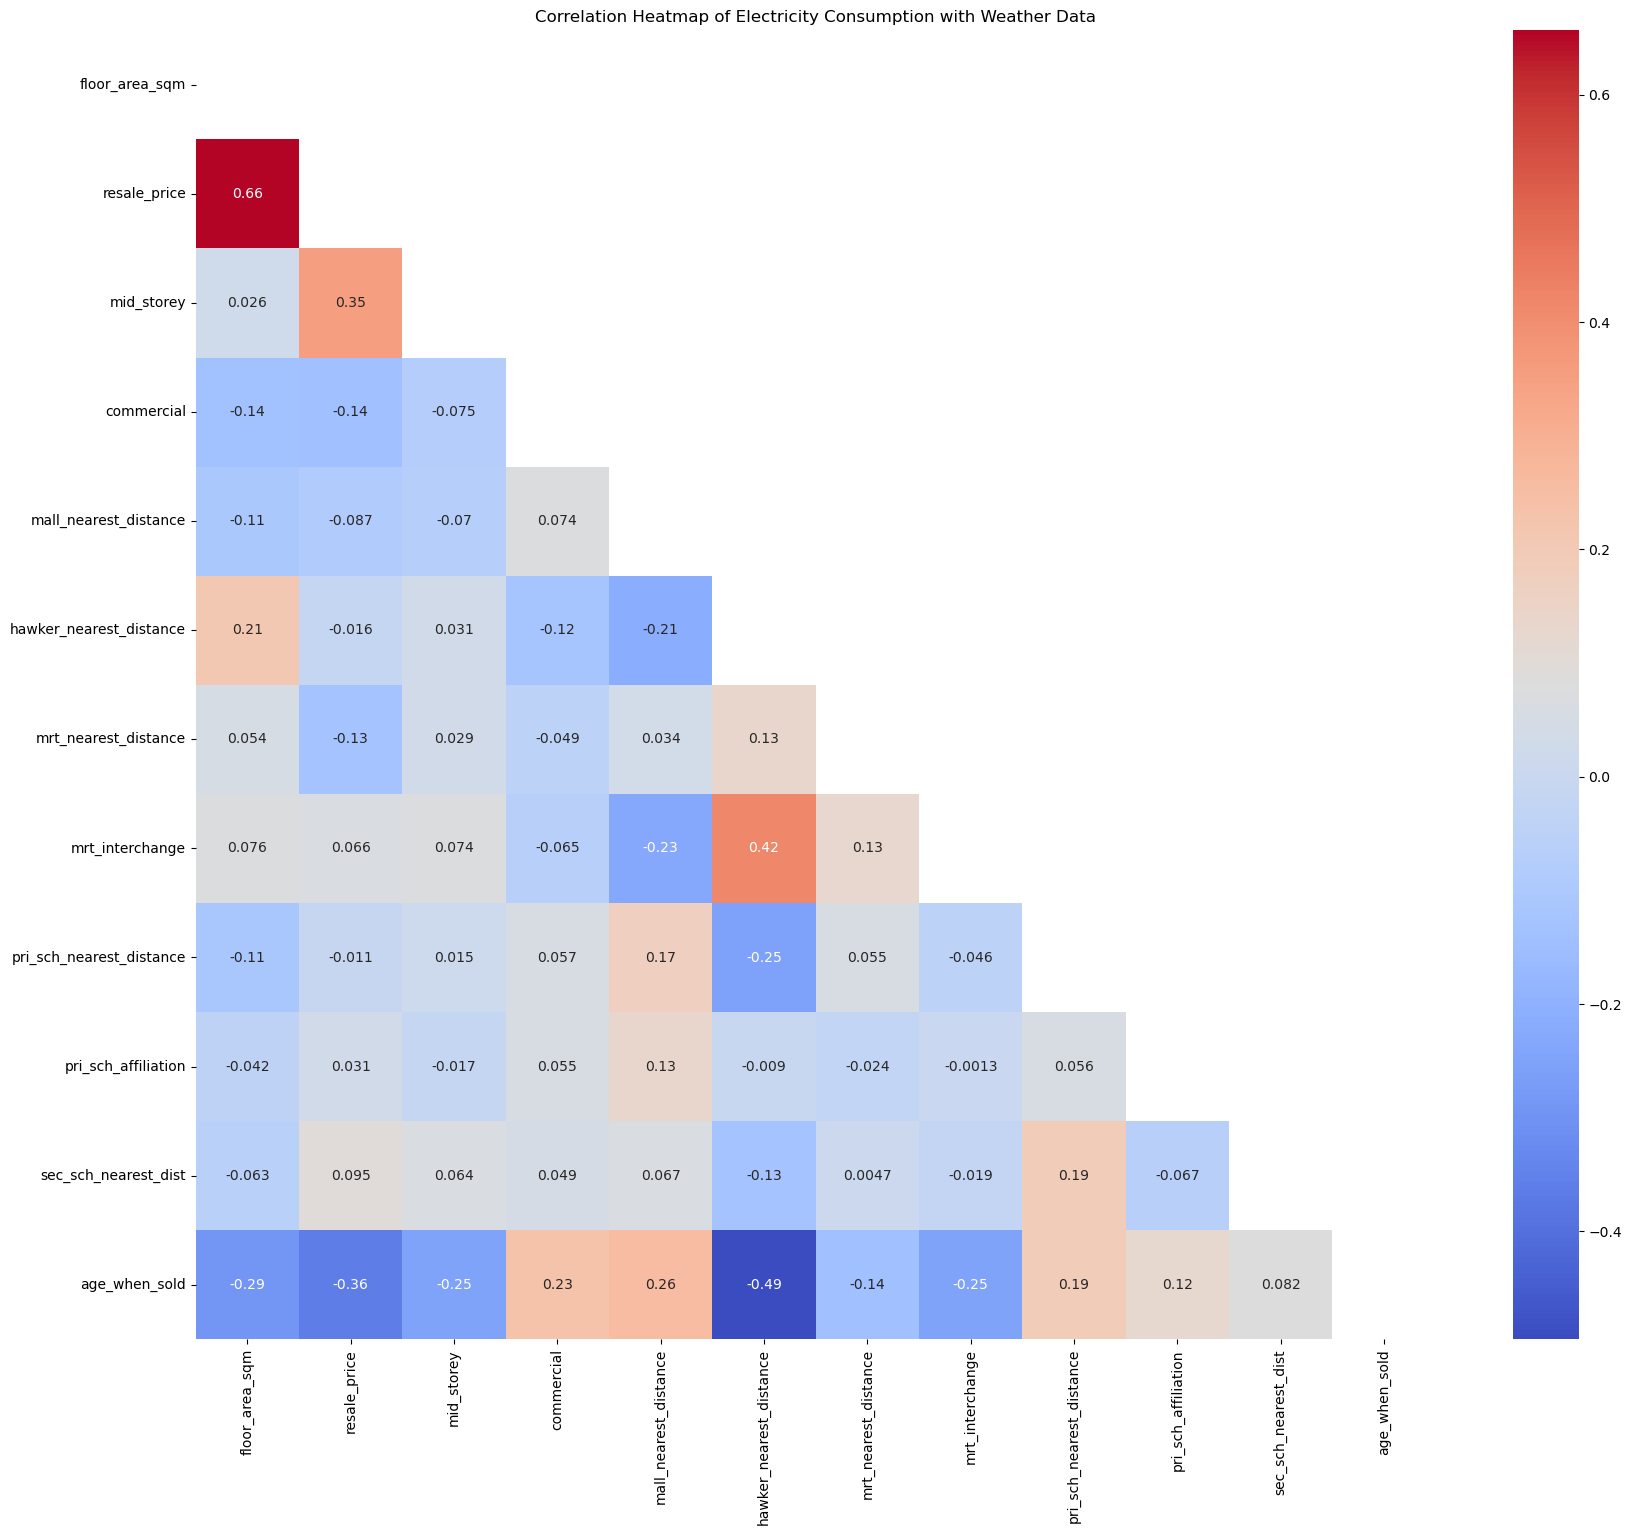

In [16]:
# plotting a heatmap with contrasting color scheme
fig, ax = plt.subplots(figsize=(20, 17))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', mask = mask)
plt.title('Correlation Heatmap of Electricity Consumption with Weather Data')
plt.show()

## 3. Exporting File

Exporting the file to use in Notebook 05.

In [17]:
df.to_csv('../data/04_cleaned_df.csv', index = False)